In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

TASK = 'cpg_methylation'
MODEL = 'hyenadna-tiny-1k'

results_dir = '../results'


bt_dir = '../results/BaseTrainer'
onthefly_dir = '../results/BatchOnTheFly'

# Default, Shuffled embeddings, Shuffled Sequential on the fly, Shuffled Batch on the fly


In [26]:
dfs_losses = []
dfs_tests = []

for experiment in os.listdir(results_dir):
    if not (experiment.startswith('bt_') or experiment.startswith('shuffled_bt') or experiment.startswith('Batch')):
        continue

    print(f'Processing {experiment}...')
    experiment_path = os.path.join(results_dir, experiment, TASK)

    for variant in os.listdir(experiment_path):
        print(f'\t Processing {variant}...')
        df_loss = pd.read_csv(os.path.join(experiment_path, variant, 'losses.csv'))
        df_loss['experiment'] = experiment
        df_loss['variant'] = variant
        dfs_losses.append(df_loss)

        try:
            df_test = pd.read_csv(os.path.join(experiment_path, variant, 'best_model_metrics.csv'))
            df_test['experiment'] = experiment
            df_test['variant'] = variant
            dfs_tests.append(df_test)
        except FileNotFoundError:
            pass
       

Processing bt_nwork_64...
	 Processing hyenadna-tiny-1k...
Processing bt_nwork_1...
	 Processing 250000...
	 Processing 100...
	 Processing 1000...
	 Processing hyenadna-tiny-1k...
Processing BatchOnTheFly...
	 Processing hyenadna-tiny-1k...
Processing shuffled_bt...
	 Processing hyenadna-tiny-1k...


In [33]:
df_losses = pd.concat(dfs_losses, ignore_index=True)
df_tests = pd.concat(dfs_tests, ignore_index=True)

df_tests['experiment'] = df_tests['experiment'].replace({'bt_nwork_64': 'Default, 64 workers', 'bt_nwork_1': 'Default', 'BatchOnTheFly': 'Shuffled Batch on the fly', 'shuffled_bt':'Shuffled'})

df_50000 = df_losses[df_losses['variant']==MODEL]
df_50000['experiment'] = df_50000['experiment'].replace({'bt_nwork_64': 'Default, 64 workers', 'bt_nwork_1': 'Default', 'BatchOnTheFly': 'Shuffled Batch on the fly', 'shuffled_bt':'Shuffled'})
df_50000

/var/folders/vw/jd7m587x06b6h1l8fgy28kpm0000gp/T/ipykernel_23221/1093778708.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_50000['experiment'] = df_50000['experiment'].replace({'bt_nwork_64': 'Default, 64 workers', 'bt_nwork_1': 'Default', 'BatchOnTheFly': 'Shuffled Batch on the fly', 'shuffled_bt':'Shuffled'})


,Epoch,train_loss,val_loss,val_auroc,experiment,variant
0,1,0.330644,0.321296,0.834721,"Default, 64 workers",hyenadna-tiny-1k
1,2,0.304027,0.310029,0.840785,"Default, 64 workers",hyenadna-tiny-1k
2,3,0.298320,0.316784,0.849526,"Default, 64 workers",hyenadna-tiny-1k
3,4,0.293795,0.316271,0.853136,"Default, 64 workers",hyenadna-tiny-1k
4,5,0.290934,0.308455,0.853942,"Default, 64 workers",hyenadna-tiny-1k
...,...,...,...,...,...,...
539,96,0.230306,0.270654,0.886602,Shuffled,hyenadna-tiny-1k
540,97,0.229181,0.277803,0.887251,Shuffled,hyenadna-tiny-1k
541,98,0.230056,0.288573,0.889284,Shuffled,hyenadna-tiny-1k
542,99,0.230063,0.296789,0.894076,Shuffled,hyenadna-tiny-1k


<Axes: xlabel='Epoch', ylabel='val_loss'>

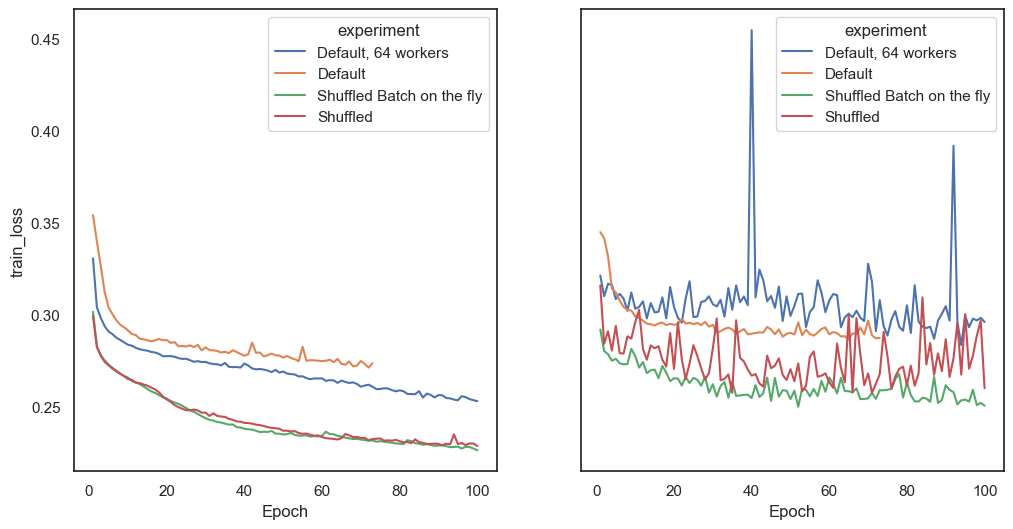

In [34]:
sns.set_theme(style="white")

fig, ax = plt.subplots(ncols=2, figsize=(12, 6), sharex=True, sharey=True)

sns.lineplot(data=df_50000, x='Epoch', y='train_loss', hue='experiment', ax=ax[0])
sns.lineplot(data=df_50000, x='Epoch', y='val_loss', hue='experiment', ax=ax[1])


<Axes: xlabel='Epoch', ylabel='val_auroc'>

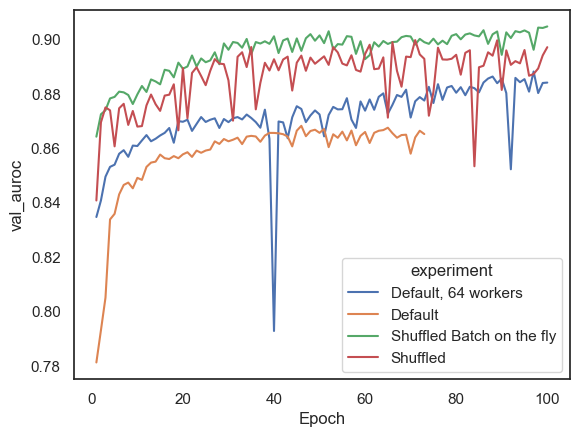

In [35]:
sns.lineplot(data=df_50000, x='Epoch', y='val_auroc', hue='experiment')

In [38]:
df_tests[['experiment','Epoch', 'train_loss','val_loss','test_auroc_avg']]

,experiment,Epoch,train_loss,val_loss,test_auroc_avg
0,"Default, 64 workers",97.0,0.255206,0.297876,0.886013
1,Shuffled Batch on the fly,100.0,0.226367,0.250596,0.903395
2,Shuffled,71.0,0.233122,0.257588,0.897200


### Compare Default to Shuffled Batch on the fly

In [43]:
def get_results_dfs(dir_path):

    losses_path = os.path.join(dir_path, 'losses.csv')
    losses_df = pd.read_csv(losses_path)
    
    val_auroc_df = losses_df.loc[:, ['Epoch', 'val_auroc']]
    
    losses_df = pd.melt(losses_df.loc[:,losses_df.columns!='val_auroc'], id_vars='Epoch', var_name='Split', value_name='BCE Loss')

    results_path = os.path.join(dir_path, 'best_model_metrics.csv')
    results_df = pd.read_csv(results_path)
    
    return losses_df, val_auroc_df, results_df


# bt_losses, bt_val_auroc, bt_results = get_results_dfs(os.path.join(results_dir,'bt_nwork_1', TASK, MODEL))
onthefly_losses, onthefly_val_auroc, onthefly_results = get_results_dfs(os.path.join(results_dir,'BatchOnTheFly', TASK, MODEL))

In [44]:
print(f"BaseTrainer - {TASK} mean AUROC: {bt_results['test_auroc_avg'].iloc[0]}")
print(f"OnTheFly - {TASK} mean AUROC: {onthefly_results['test_auroc_avg'].iloc[0]}")

NameError: name 'bt_results' is not defined

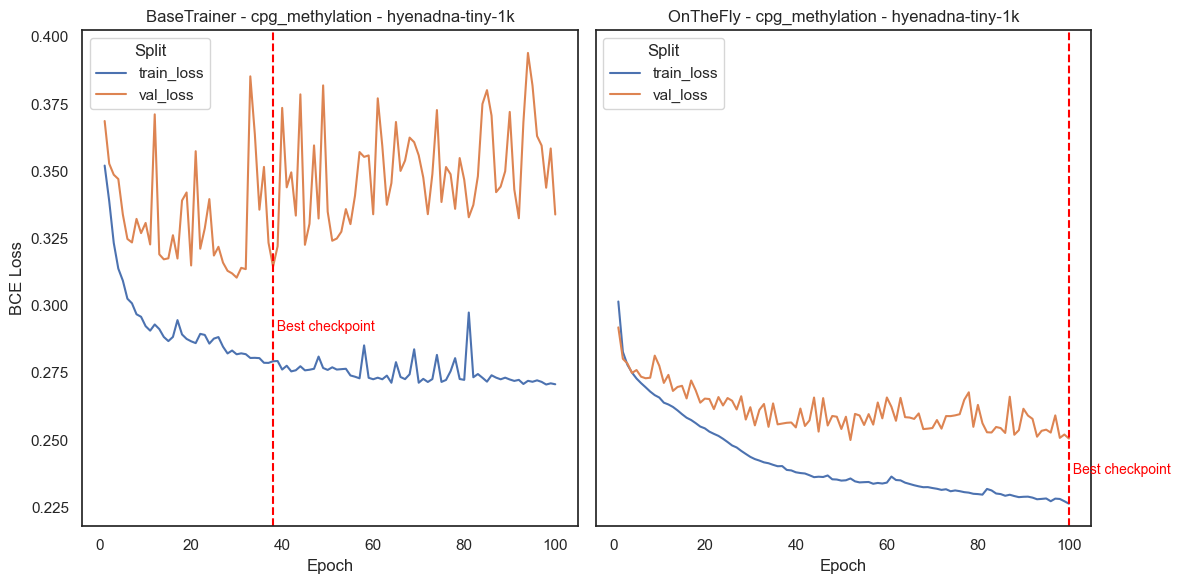

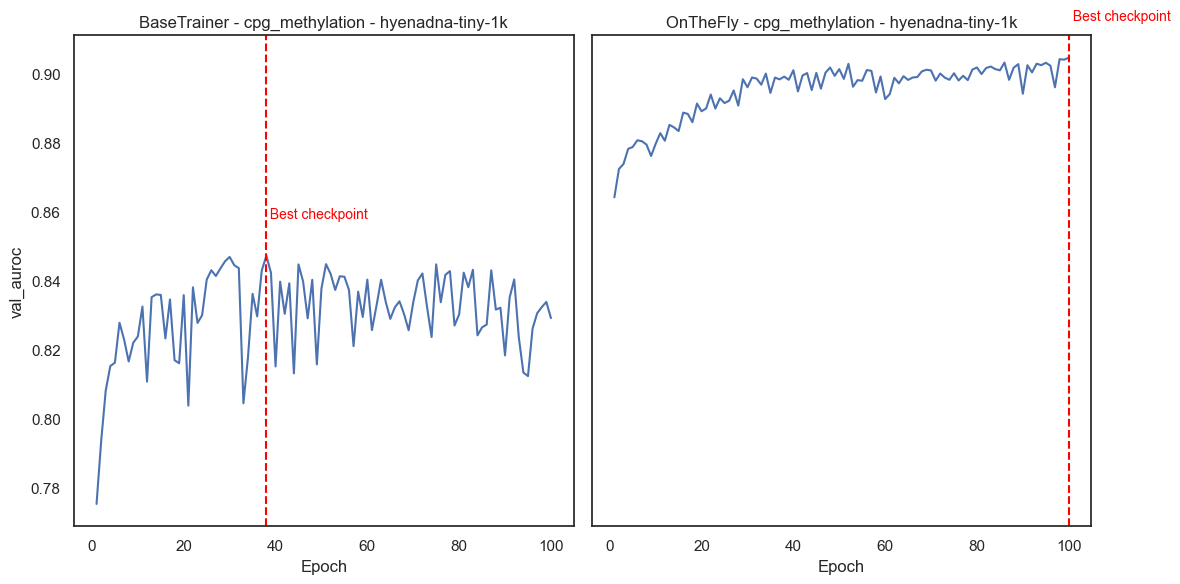

In [38]:
def print_checkpoint(ax, results_df, value_col='train_loss'):
    ax.axvline(x=results_df['Epoch'][0], color='red', linestyle='--', linewidth=1.5)
    ax.text(results_df['Epoch'][0], results_df[value_col][0]+.01, ' Best checkpoint', 
            horizontalalignment='left', verticalalignment='bottom', color='red', fontsize=10)

sns.set_theme(style="white")

fig, ax = plt.subplots(ncols=2, figsize=(12, 6), sharex=True, sharey=True)
sns.lineplot(data=bt_losses, x='Epoch', y='BCE Loss', hue='Split', ax=ax[0])
sns.lineplot(data=onthefly_losses, x='Epoch', y='BCE Loss', hue='Split', ax=ax[1])
ax[0].set_title(f'BaseTrainer - {TASK} - {MODEL}')
print_checkpoint(ax[0], bt_results)
ax[1].set_title(f'OnTheFly - {TASK} - {MODEL}')
print_checkpoint(ax[1], onthefly_results)
plt.tight_layout()

fig, ax = plt.subplots(ncols=2, figsize=(12,6),sharex=True, sharey=True)
sns.lineplot(data=bt_val_auroc, x='Epoch', y='val_auroc', ax=ax[0])
sns.lineplot(data=onthefly_val_auroc, x='Epoch', y='val_auroc', ax=ax[1])
ax[0].set_title(f'BaseTrainer - {TASK} - {MODEL}')
print_checkpoint(ax[0], bt_results, value_col='val_auroc')
ax[1].set_title(f'OnTheFly - {TASK} - {MODEL}')
print_checkpoint(ax[1], onthefly_results, value_col='val_auroc')
plt.tight_layout()
